In [1]:
import gzip
import json
def readJSON(path):
  for l in gzip.open(path, 'rt'):
    d = json.loads(l)
    u = d['user_id']
    try:
      g = d['gmap_id']
    except Exception as e:
      g = None
    yield u,g,d

In [4]:
data = []
counter = 0
for user,map_id,d in readJSON("review-District_of_Columbia.json.gz"):
  if counter == 10000:
    break
  data.append((user, map_id, d['text'], d['rating']))
  counter += 1

print(data[0])


('107074390665313624214', '0x89b7b7851b06ef6b:0x5f356b1eb1da27', 'The venue is underground. Nice spot to grab a quick gelato or coffee. Food did not look great otherwise. Staff at the gelato place is rude and not nice at all. Service is fast. It is perfectly located in between west and east buildings.', 4)


In [5]:
import pandas as pd


df = pd.DataFrame(data, columns=['user_id', 'gmap_id', 'text', 'rating'])


In [6]:
%pip install numpy pandas nltk scipy scikit-learn scikit-surprise


  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/60/90/81ac364ef94209c100e12579629dc92bf7a709a84af32f8c551b02c07e94/nltk-3.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/98/78/01c019cdb5d6498122777c1a43056ebb3ebfeef2076d9d026bfe15583b2b/click-8.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 10.4 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-macosx_11_0_arm64.whl size=467518 sha256=e45a3b1ae2df402c545268b1b11e27946736e8b2df1a8dc5f0377d95ca3ab591
  Stored in directory: /Users/madh

In [19]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
import numpy as np
from collections import namedtuple

Prediction = namedtuple('Prediction', ['uid', 'iid', 'r_ui', 'est', 'details'])

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'gmap_id', 'rating']], reader)

train_data, test_data = train_test_split(data, test_size = 0.2)

algo = SVD()
algo.fit(train_data)

global_mean = algo.trainset.global_mean

baseline_predictions = []


for uid, iid, r_ui in test_data:
    
    pred = Prediction(
        uid=uid,
        iid=iid,
        r_ui=r_ui,
        est=global_mean,
        details={'was_baseline': True}
    )
    baseline_predictions.append(pred)

rmse_baseline = accuracy.rmse(baseline_predictions, verbose=False)

print(f"Global Mean Baseline RMSE: {rmse_baseline:.4f}")
print(f"Global Mean Baseline MSE (Error): {rmse_baseline**2:.4f}")



Global Mean Baseline RMSE: 1.2558
Global Mean Baseline MSE (Error): 1.5770


In [22]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
import numpy as np
from collections import namedtuple

Prediction = namedtuple('Prediction', ['uid', 'iid', 'r_ui', 'est', 'details'])

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'gmap_id', 'rating']], reader)

train_data, test_data = train_test_split(data, test_size = 0.2)

algo = SVD()
algo.fit(train_data)

trainset = algo.trainset

user_mean_ratings = {}

for user_inner_id, ratings_list in trainset.ur.items():

    ratings = [r for (_, r) in ratings_list]
    
    mean_rating = np.mean(ratings)
    
    user_mean_ratings[user_inner_id] = mean_rating

user_mean_baseline_predictions = []
global_mean = algo.trainset.global_mean

for user_raw_id, item_raw_id, true_rating in test_data:
    try:
        user_inner_id = trainset.to_inner_uid(user_raw_id)
        
        predicted_rating = user_mean_ratings.get(user_inner_id)
        
    except ValueError:
        predicted_rating = global_mean

    pred = Prediction(
        uid=user_raw_id,
        iid=item_raw_id,
        r_ui=true_rating,
        est=predicted_rating,
        details={'was_user_baseline': True}
    )
    user_mean_baseline_predictions.append(pred)

rmse_user_mean_baseline = accuracy.rmse(user_mean_baseline_predictions, verbose=False)

print(f"\nUser Mean Baseline RMSE: {rmse_user_mean_baseline:.4f}")
print(f"\nUser Mean Baseline MSE: {rmse_user_mean_baseline**2:.4f}")


User Mean Baseline RMSE: 1.2256

User Mean Baseline MSE: 1.5022


In [20]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
import numpy as np

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'gmap_id', 'rating']], reader)

train_data, test_data = train_test_split(data, test_size = 0.2)

model = SVD(n_factors = 3, reg_all = 0.1, lr_all = 0.0008 , n_epochs = 100)
model.fit(train_data)
predictions_train = model.test(train_data.build_testset())
accuracy.rmse(predictions_train)
predictions = model.test(test_data)
new_rmse = accuracy.rmse(predictions)
print("Error: ", accuracy.rmse(predictions)**2)

RMSE: 1.0165
RMSE: 1.1070
RMSE: 1.1070
Error:  1.2253421768107928


In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashwathboomi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ashwathboomi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ashwathboomi/nltk_data...


True

In [8]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)


def preprocess_text(text):
    text = str(text).lower()
    tokens = text.split()

    cleaned_tokens = []
    for token in tokens:
        clean_token = ''.join(c for c in token if c not in punctuation)
        if clean_token and clean_token not in stop_words and len(clean_token) > 2:
            cleaned_tokens.append(lemmatizer.lemmatize(clean_token))
    return " ".join(cleaned_tokens)


df['cleaned_text'] = df['text'].apply(preprocess_text)

X = df['cleaned_text']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,2), analyzer='word', min_df = 1, max_df=0.90, sublinear_tf=True)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model = LinearRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)


mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error for the Regression Model: {mse}")


Mean Squared Error for the Regression Model: 1.3249539177725396


In [9]:
import pandas as pd
import gzip
import json
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack, csr_matrix
import numpy as np
from surprise import SVD, Dataset, Reader

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer()
except LookupError:
    nltk.download('wordnet')


data_file_path = "review-District_of_Columbia.json.gz"

data_list = []
counter = 0
for user, map_id, d in readJSON(data_file_path):
    if counter == 10000:
        break
    data_list.append((user, map_id, d['text'], d['rating']))
    counter += 1


df = pd.DataFrame(data_list, columns=['user_id', 'gmap_id', 'text', 'rating'])

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)


df['cleaned_text'] = df['text'].apply(preprocess_text)

reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(df[['user_id', 'gmap_id', 'rating']], reader)
trainset = surprise_data.build_full_trainset()
svd_predictor = SVD(n_factors=3, reg_all=0.1, lr_all=0.0008, n_epochs=100)
svd_predictor.fit(trainset)

svd_predictions = []
for index, row in df.iterrows():
    user_id = row['user_id']
    gmap_id = row['gmap_id']
    prediction = svd_predictor.predict(user_id, gmap_id)
    svd_predictions.append(prediction.est)
df['svd_predicted_rating'] = svd_predictions

vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,2), analyzer='word', min_df=1, max_df=0.90, sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])
print("\nTF-IDF vectorization completed. Shape of X_tfidf:", X_tfidf.shape)

svd_features_dense = df['svd_predicted_rating'].to_numpy().reshape(-1, 1)
svd_features_sparse = csr_matrix(svd_features_dense)
X_combined = hstack([X_tfidf, svd_features_sparse])
print("\nCombined feature matrix created. Shape of X_combined:", X_combined.shape)


# Predicting whether or not it is positive
# df['is_positive'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
# y = df['is_positive']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

log_reg_model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)
y_pred = log_reg_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 (macro): {f1:.4f}")




TF-IDF vectorization completed. Shape of X_tfidf: (10000, 15000)

Combined feature matrix created. Shape of X_combined: (10000, 15001)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.7985
Precision (macro): 0.5594
Recall (macro): 0.3594
F1 (macro): 0.3549


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
import pandas as pd
import gzip
import json
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

def readJSON(path):
  for l in gzip.open(path, 'rt'):
    d = json.loads(l)
    u = d['user_id']
    try:
      g = d['gmap_id']
    except Exception as e:
      g = None
    yield u,g,d

data = []
counter = 0
for user,map_id,d in readJSON("review-District_of_Columbia.json.gz"):
  if counter == 10000:
    break
  data.append((user, map_id, d['text'], d['rating']))
  counter += 1

df = pd.DataFrame(data, columns=['user_id', 'gmap_id', 'text', 'rating'])

# Re-initialize Reader and Dataset for SVD
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'gmap_id', 'rating']], reader)

# Get a full trainset to train on all data for predictions
trainset = data.build_full_trainset()
svd_predictor = SVD(n_factors=3, reg_all=0.1, lr_all=0.0008, n_epochs=100)
svd_predictor.fit(trainset)

svd_predictions = []

for index, row in df.iterrows():
    user_id = row['user_id']
    gmap_id = row['gmap_id']
    # Use the svd_predictor to get the prediction
    prediction = svd_predictor.predict(user_id, gmap_id)
    svd_predictions.append(prediction.est)

df['svd_predicted_rating'] = svd_predictions

print("SVD-based predicted ratings generated and added to the DataFrame.")
print(df.head())

SVD-based predicted ratings generated and added to the DataFrame.
                 user_id                                gmap_id  \
0  101855823232666695168  0x89c24469c758686b:0x641f5b84cb9bedfa   
1  105821946869087882225  0x89c24469c758686b:0x641f5b84cb9bedfa   
2  108990883320903443748  0x89c24469c758686b:0x641f5b84cb9bedfa   
3  117021514778630212205  0x89c24469c758686b:0x641f5b84cb9bedfa   
4  113722104692308235141    0x89c25fc9494dce47:0x6d63c807b59a55   

                                                text  rating  \
0  Natalia may be the worst agent I have ever dea...       1   
1  The lady at the front desk is rude. The bathro...       1   
2  Worst agent in New York and Brooklyn, dont was...       1   
3                                               None       5   
4  I'm late to posting this but this store especi...       5   

   svd_predicted_rating  
0              3.554723  
1              3.470610  
2              3.437804  
3              3.863813  
4              3

In [23]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK data if not already present
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer()
except LookupError:
    nltk.download('wordnet')

# Define preprocessing components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)

# Define preprocess_text function
def preprocess_text(text):
    text = str(text).lower() # Ensure text is string and convert to lowercase
    tokens = text.split()

    cleaned_tokens = []
    for token in tokens:
        clean_token = ''.join(c for c in token if c not in punctuation)
        if clean_token and clean_token not in stop_words and len(clean_token) > 2:
            cleaned_tokens.append(lemmatizer.lemmatize(clean_token))
    return " ".join(cleaned_tokens)

# Apply preprocessing to the 'text' column of the DataFrame to ensure 'cleaned_text' exists
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Initialize and fit TfidfVectorizer on the entire 'cleaned_text' column
vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,2), analyzer='word', min_df=1, max_df=0.90, sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])

print("TF-IDF vectorization completed. Shape of X_tfidf:", X_tfidf.shape)
print("First 5 feature names:", vectorizer.get_feature_names_out()[:5])

TF-IDF vectorization completed. Shape of X_tfidf: (10000, 15000)
First 5 feature names: ['100' '100 original' '100 percent' '100 por' '100 recommend']


In [24]:
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Convert svd_predicted_rating to a NumPy array and reshape it to a 2D column vector
svd_features_dense = df['svd_predicted_rating'].to_numpy().reshape(-1, 1)

# Convert the dense SVD features into a sparse CSR matrix
svd_features_sparse = csr_matrix(svd_features_dense)

# Horizontally stack the TF-IDF feature matrix with the SVD feature matrix
X_combined = hstack([X_tfidf, svd_features_sparse])

print("Combined feature matrix created. Shape of X_combined:", X_combined.shape)
print("The first 5 rows of the combined feature matrix (first 5 TF-IDF features and SVD feature):")
print(X_combined[:5, :5].toarray()) # Print first 5 TF-IDF features and the SVD feature for the first 5 rows

Combined feature matrix created. Shape of X_combined: (10000, 15001)
The first 5 rows of the combined feature matrix (first 5 TF-IDF features and SVD feature):
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Define the target variable for classification
# df['is_positive'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Prepare target variable
y = df['rating']

# 3. Split the combined feature matrix (X_combined) and the target variable (y) into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# 5. Initialize a Logistic Regression model
# Using 'saga' solver which handles L1/L2 regularization and sparse data well, and setting max_iter for convergence.
log_reg_model = LogisticRegression(solver='saga', max_iter=3000, random_state=42)

# 6. Train the Logistic Regression model
log_reg_model.fit(X_train, y_train)

# 7. Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# 9. Calculate and print the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

print(f"\nLogistic Regression Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Shape of X_train: (8000, 15001)
Shape of X_test: (2000, 15001)
Shape of y_train: (8000,)
Shape of y_test: (2000,)

Logistic Regression Model Performance:
Accuracy: 0.8440
Precision: 0.9303
Recall: 0.9766
F1-Score: 0.9529


In [17]:
print(df['rating'].value_counts())
print("\nProportions:")
print(df['rating'].value_counts(normalize=True))


rating
5    7798
1     980
4     720
3     330
2     172
Name: count, dtype: int64

Proportions:
rating
5    0.7798
1    0.0980
4    0.0720
3    0.0330
2    0.0172
Name: proportion, dtype: float64


## Part 2:

# Task
Try to recommend where a given user should visit next given their previous reviews, history, and metadata.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from scipy.sparse import csr_matrix, vstack
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold

In [2]:
# given a state's review and metadata file, load into a dataframe with the following schema
# gmap_id, latitude, longitude, name, category
def load_data(json_path, meta_path, state, compression=False):
    if compression:
        df_json = pd.read_json(json_path, lines=True, compression='gzip')
    else:
        df_json = pd.read_json(json_path, lines=True)
    df_json['State'] = state
    df_json.drop(columns=['pics'], inplace=True, errors='ignore')
    df_json['datetime'] = pd.to_datetime(df_json['time'], unit='ms', errors='coerce')
    df_json.sort_values(by=['user_id', 'datetime'], inplace=True)
    df_json['day_of_week'] = df_json['datetime'].dt.day_name()
    df_json['prev_time'] = df_json.groupby('user_id')['datetime'].shift(1)
    df_json['days_diff'] = (df_json['datetime'] - df_json['prev_time']).dt.days
    df_json['days_diff'].fillna(0, inplace=True)
    if compression:
        df_meta = pd.read_json(meta_path, lines=True, compression='gzip')
    else:
        df_meta = pd.read_json(meta_path, lines=True)
    wanted_cols = ['gmap_id', 'latitude', 'longitude', 'name', 'category']
    existing_cols = [c for c in wanted_cols if c in df_meta.columns]
    df_meta_clean = df_meta[existing_cols]
    full_data = pd.merge(df_json, df_meta_clean, on='gmap_id', how='left')
    return full_data

In [3]:
# data exploration: plot business_density, get top categories
def business_density_plot(window_size, full_df, state, out_path=None):
    lat_center = full_df['latitude'].median()
    lon_center = full_df['longitude'].median()
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.scatter(full_df['longitude'], full_df['latitude'], alpha=0.1, s=3, c='blue', label='Review')
    ax.set_title(f'{state}: Urban Density ({window_size}° Window)')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(lon_center - window_size, lon_center + window_size)
    ax.set_ylim(lat_center - window_size, lat_center + window_size)
    ax.legend()
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300)
    return fig, ax

def get_top_categories(df, state_name, out_path=None):
    exploded = df['category'].dropna().explode()
    top_counts = exploded.value_counts().head(10)
    df_plot = top_counts.reset_index()
    df_plot.columns = ['Category_Name', 'Review_Count']
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=df_plot, x='Review_Count', y='Category_Name', palette='Blues_r', ax=ax)
    ax.set_title(f'Top Business Categories ({state_name})')
    ax.set_xlabel('Number of Reviews')
    ax.set_ylabel('')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300)
    return fig, ax

In [4]:
# localize time by region timezone
def localize_time(df, region_timezone):
    if df['datetime'].dt.tz is None:
        df['datetime'] = df['datetime'].dt.tz_localize('UTC')
    df['local_time'] = df['datetime'].dt.tz_convert(region_timezone)
    df['local_hour'] = df['local_time'].dt.hour
    return df

# get user per state activity by the hour
def activity_by_hour_plot(df, region_timezone, state, out_path=None):
    df = localize_time(df, region_timezone)
    df['fractional_hour'] = df['local_time'].dt.hour + (df['local_time'].dt.minute / 60.0)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(df['fractional_hour'].dropna(), label=state, fill=True, bw_adjust=1.5, ax=ax)
    ax.set_title('User Activity by Time of Day')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Density of Activity')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 2))
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300)
    return fig, ax

In [5]:
# computes distance from user to businesses 
def haversine(user_lat, user_lon, place_lats, place_lons):
    lat1 = np.radians(user_lat)
    lon1 = np.radians(user_lon)
    lat2 = np.radians(place_lats)
    lon2 = np.radians(place_lons)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(np.clip(a, 0, 1)))
    R = 6371.0
    return R * c

# plot distributions of travel distances by state
def plot_distances(df, state, out_path=None):
    df = df.copy()
    df['prev_lat'] = df.groupby('user_id')['latitude'].shift(1)
    df['prev_lon'] = df.groupby('user_id')['longitude'].shift(1)
    df['dist_km'] = haversine(df['prev_lat'].values, df['prev_lon'].values,
                                        df['latitude'].values, df['longitude'].values)
    state_dist = df[df['dist_km'].between(0.1, 100)]['dist_km'].dropna()
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if not state_dist.empty:
        sns.kdeplot(state_dist, ax=axes[0], fill=True, label=state, clip=(0, 100))
    axes[0].set_title('Distribution of Travel Distances (Density)')
    axes[0].set_xlabel('Distance (km)')
    axes[0].set_xlim(0, 50)
    axes[0].legend()
    if not state_dist.empty:
        sns.ecdfplot(state_dist, ax=axes[1], label=state)
    axes[1].set_title('CDF: Probability of Visiting within X km')
    axes[1].set_xlabel('Distance (km)')
    axes[1].set_ylabel('Proportion of Trips')
    axes[1].set_xlim(0, 50)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300)
    return fig, axes

In [6]:
# clean and split data into train and test samples
def split_data(df):
    user_counts = df['user_id'].value_counts()
    valid_users = user_counts[user_counts >= 2].index
    filtered_df = df[df['user_id'].isin(valid_users)].copy()
    test_df = filtered_df.groupby('user_id').tail(1)
    train_df = filtered_df.drop(test_df.index)
    user_history = train_df.groupby('user_id')['gmap_id'].apply(set).to_dict()
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    popular_places = train_df['gmap_id'].value_counts().index.tolist()
    user_sets = train_df.groupby('user_id')['gmap_id'].apply(set).to_dict()
    place_locs = train_df.drop_duplicates('gmap_id').set_index('gmap_id')[['latitude', 'longitude']].to_dict('index')
    return train_df, test_df, user_history, popular_places, user_sets, place_locs

# build user-place interaction matrix
def build_interaction_matrix(train_df):
    users = train_df['user_id'].unique()
    places = train_df['gmap_id'].unique()
    user_to_idx = {u: i for i, u in enumerate(users)}
    place_to_idx = {p: j for j, p in enumerate(places)}
    idx_to_place = {j: p for p, j in place_to_idx.items()}

    rows = [user_to_idx[u] for u in train_df['user_id']]
    cols = [place_to_idx[p] for p in train_df['gmap_id']]
    data = np.ones(len(rows), dtype=np.int8)
    M = csr_matrix((data, (rows, cols)), shape=(len(users), len(places)), dtype=np.int8)

    user_degrees = np.ravel(M.sum(axis=1))
    place_degrees = np.ravel(M.sum(axis=0))

    place_ids = np.array(places)
    place_coords_df = train_df.drop_duplicates('gmap_id').set_index('gmap_id').loc[place_ids][['latitude', 'longitude']]
    place_lats = place_coords_df['latitude'].values
    place_lons = place_coords_df['longitude'].values

    return {
        'M': M,
        'users': users,
        'places': places,
        'user_to_idx': user_to_idx,
        'place_to_idx': place_to_idx,
        'idx_to_place': idx_to_place,
        'user_degrees': user_degrees,
        'place_degrees': place_degrees,
        'place_ids': place_ids,
        'place_lats': place_lats,
        'place_lons': place_lons
    }

In [7]:
# predict popular places to users that haven't visited them
def predict_popularity(user_id, user_history, popular_places, top_k=10):
    seen = user_history.get(user_id, set())
    recommendations = []
    for item in popular_places:
        if item not in seen:
            recommendations.append(item)
            if len(recommendations) >= top_k:
                break
    return recommendations

# predict places based on distance from user 
def predict_distance(user_id, current_lat, current_lon, user_history, idx_struct, top_k=10):
    seen = user_history.get(user_id, set())
    place_lats = idx_struct['place_lats']
    place_lons = idx_struct['place_lons']
    dists = haversine(current_lat, current_lon, place_lats, place_lons)
    if seen:
        seen_idx = [idx_struct['place_to_idx'][p] for p in seen if p in idx_struct['place_to_idx']]
        if seen_idx:
            dists[seen_idx] = np.inf
    k = min(top_k, len(dists))
    idx = np.argpartition(dists, k - 1)[:k]
    idx = idx[np.argsort(dists[idx])]
    return list(idx_struct['place_ids'][idx])

In [8]:
# predict places for a user by jaccard score with other users' visited places
def predict_jaccard(target_user, idx_struct, top_k=10, neighbor_limit=50):
    if target_user not in idx_struct['user_to_idx']:
        return []
    M = idx_struct['M']
    u_idx = idx_struct['user_to_idx'][target_user]
    target_row = M[u_idx]
    intersections = np.ravel(M.dot(target_row.T).toarray())  # intersections per user
    intersections[u_idx] = 0
    user_deg = idx_struct['user_degrees']
    unions = user_deg + user_deg[u_idx] - intersections
    valid = unions > 0
    jaccard_scores = np.zeros_like(intersections, dtype=float)
    jaccard_scores[valid] = intersections[valid] / unions[valid]
    neighbor_idx = np.argpartition(-jaccard_scores, min(neighbor_limit, len(jaccard_scores)-1))[:neighbor_limit]
    neighbor_weights = jaccard_scores[neighbor_idx]
    neighbor_weights = neighbor_weights[neighbor_weights > 0]
    if neighbor_weights.size == 0:
        return []
    neighbor_idx = neighbor_idx[:len(neighbor_weights)]
    neighbor_rows = M[neighbor_idx]
    candidate_scores = neighbor_rows.T.dot(neighbor_weights)
    target_places_indices = target_row.indices
    if target_places_indices.size > 0:
        candidate_scores[target_places_indices] = 0
    k = min(top_k, candidate_scores.shape[0])
    top_idx = np.argpartition(-candidate_scores, k - 1)[:k]
    top_idx = top_idx[np.argsort(-candidate_scores[top_idx])]
    return list(idx_struct['place_ids'][top_idx])

In [9]:
# predict places for a user by jaccard score with other users' visited places
def get_jaccard_scores(target_user, idx_struct, neighbor_limit=50):
    if target_user not in idx_struct['user_to_idx']:
        return {}
    M = idx_struct['M']
    u_idx = idx_struct['user_to_idx'][target_user]
    target_row = M[u_idx]
    intersections = np.ravel(M.dot(target_row.T).toarray())
    intersections[u_idx] = 0
    user_deg = idx_struct['user_degrees']
    unions = user_deg + user_deg[u_idx] - intersections
    valid = unions > 0
    jaccard_scores = np.zeros_like(intersections, dtype=float)
    jaccard_scores[valid] = intersections[valid] / unions[valid]
    neighbor_idx = np.argpartition(-jaccard_scores, min(neighbor_limit, len(jaccard_scores)-1))[:neighbor_limit]
    neighbor_weights = jaccard_scores[neighbor_idx]
    mask = neighbor_weights > 0
    neighbor_idx = neighbor_idx[mask]
    neighbor_weights = neighbor_weights[mask]
    if neighbor_idx.size == 0:
        return {}
    neighbor_rows = M[neighbor_idx]
    candidate_scores = neighbor_rows.T.dot(neighbor_weights)
    target_places_indices = target_row.indices
    if target_places_indices.size > 0:
        candidate_scores[target_places_indices] = 0
    place_ids = idx_struct['place_ids']
    return {place_ids[i]: float(candidate_scores[i]) for i in np.nonzero(candidate_scores)[0]}


In [10]:
# uses multiple prediction methods - jaccard, distance
def predict_weighted_hybrid(user_id, current_lat, current_lon, idx_struct, user_sets, top_k=10):
    jaccard_dict = get_jaccard_scores(user_id, idx_struct)
    if not jaccard_dict:
        return predict_distance(user_id, current_lat, current_lon, user_sets, idx_struct, top_k=top_k)
    place_index_map = idx_struct['place_to_idx']
    place_lats = idx_struct['place_lats']
    place_lons = idx_struct['place_lons']
    j_items = np.array(list(jaccard_dict.keys()))
    j_scores = np.array(list(jaccard_dict.values()))
    j_idx = np.array([place_index_map[p] for p in j_items if p in place_index_map])
    if j_idx.size == 0:
        return predict_distance(user_id, current_lat, current_lon, user_sets, idx_struct, top_k=top_k)
    dists = haversine(current_lat, current_lon, place_lats[j_idx], place_lons[j_idx])
    distance_factor = 1.0 / (np.log1p(dists) + 0.5)
    final_scores = j_scores[:len(j_idx)] * distance_factor
    k = min(top_k, final_scores.shape[0])
    top = np.argpartition(-final_scores, k - 1)[:k]
    top = top[np.argsort(-final_scores[top])]
    return list(j_items[top])

In [11]:
# factorizes the user-place interaction matrix into latent user and place vectors. 
# scores places via the dot product with a user’s vector, excluding already visited places, and selects the top scores.
def train_svd_optimized(idx_struct, n_components=20, random_state=42):
    M = idx_struct['M']
    n_comp = min(n_components, M.shape[0] - 1 if M.shape[0] > 1 else 1, M.shape[1] - 1 if M.shape[1] > 1 else 1)
    if n_comp < 1:
        n_comp = 1
    svd = TruncatedSVD(n_components=n_comp, random_state=random_state)
    user_factors = svd.fit_transform(M)
    place_factors = svd.components_
    return user_factors, place_factors

def predict_svd(user_id, user_history, idx_struct, user_factors, place_factors, top_k=10):
    if user_id not in idx_struct['user_to_idx']:
        return []
    user_to_idx = idx_struct['user_to_idx']
    place_ids = idx_struct['place_ids']
    place_to_idx = idx_struct['place_to_idx']
    u_idx = user_to_idx[user_id]
    user_vector = user_factors[u_idx]
    scores = np.dot(user_vector, place_factors)
    seen_items = user_history.get(user_id, set())
    if seen_items:
        seen_indices = [place_to_idx[i] for i in seen_items if i in place_to_idx]
        if seen_indices:
            scores[seen_indices] = -np.inf
    k = min(top_k, scores.shape[0])
    top_indices = np.argpartition(-scores, k - 1)[:k]
    top_indices = top_indices[np.argsort(-scores[top_indices])]
    return list(place_ids[top_indices])

In [31]:
from tqdm import tqdm

# Evaluates different methods of user-item prediction
def evaluate_methods(train_df, test_df, user_history, popular_places, user_sets, place_locs, sample_limit=100000):
    idx_struct = build_interaction_matrix(train_df)
    user_factors, place_factors = train_svd_optimized(idx_struct, n_components=20)
    hits = {'pop': 0, 'dist': 0, 'jaccard': 0, 'hybrid': 0, 'svd': 0}
    total = 0
    sample_test_users = list(test_df['user_id'].unique())[:sample_limit]

    for user in tqdm(sample_test_users, desc="Evaluating users"):
        true_place_series = test_df[test_df['user_id'] == user]['gmap_id'].values
        if len(true_place_series) == 0:
            continue
        true_place = true_place_series[0]
        user_train_data = train_df[train_df['user_id'] == user]
        if user_train_data.empty:
            continue
        last_lat = user_train_data.iloc[-1]['latitude']
        last_lon = user_train_data.iloc[-1]['longitude']
        preds_pop = predict_popularity(user, user_history, popular_places, top_k=10)
        preds_dist = predict_distance(user, last_lat, last_lon, user_history, idx_struct, top_k=10)
        preds_jaccard = predict_jaccard(user, idx_struct, top_k=10)
        preds_hybrid = predict_weighted_hybrid(user, last_lat, last_lon, idx_struct, user_sets, top_k=10)
        preds_svd = predict_svd(user, user_history, idx_struct, user_factors, place_factors, top_k=10)
        if true_place in preds_pop: hits['pop'] += 1
        if true_place in preds_dist: hits['dist'] += 1
        if true_place in preds_jaccard: hits['jaccard'] += 1
        if true_place in preds_hybrid: hits['hybrid'] += 1
        if true_place in preds_svd: hits['svd'] += 1
        total += 1

    if total == 0:
        print("No test users processed. Check split_data or data sufficiency.")
        return

    print(f"\n--- Results (Hit Rate @ 10) ---")
    print(f"Popularity: {hits['pop'] / total:.4f}")
    print(f"Distance:   {hits['dist'] / total:.4f}")
    print(f"Jaccard:    {hits['jaccard'] / total:.4f}")
    print(f"Hybrid:     {hits['hybrid'] / total:.4f}")
    print(f"SVD:        {hits['svd'] / total:.4f}")


In [ ]:
dc_json_path = './datasets/review-District_of_Columbia.json'
wy_json_path = './datasets/review-Wyoming.json'
dc_meta_path = './datasets/meta-District_of_Columbia.json'
wy_meta_path = './datasets/meta-Wyoming.json'
# load in data
df_dc = load_data(dc_json_path, dc_meta_path, 'DC')
df_wy = load_data(wy_json_path, wy_meta_path, 'WY')
df_full = pd.concat([df_dc, df_wy], ignore_index=True)

# 5-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df_full['fold'] = -1

for fold, (_, val_idx) in enumerate(skf.split(X=df_full, y=df_full['State'])):
    df_full.loc[val_idx, 'fold'] = fold

In [ ]:
# save dataframe to CSV
df_full.to_csv('datasets/combined_reviews_folds.csv', index=False, compression='gzip')

In [15]:
# read in dataframe that was previously saved
# this is more efficient if no changes to preprocessing were done
df_full = pd.read_csv('datasets/combined_reviews_folds.csv', compression='gzip')

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Distribution of Travel Distances (Density)'}, xlabel='Distance (km)', ylabel='Density'>,
        <Axes: title={'center': 'CDF: Probability of Visiting within X km'}, xlabel='Distance (km)', ylabel='Proportion of Trips'>],
       dtype=object))

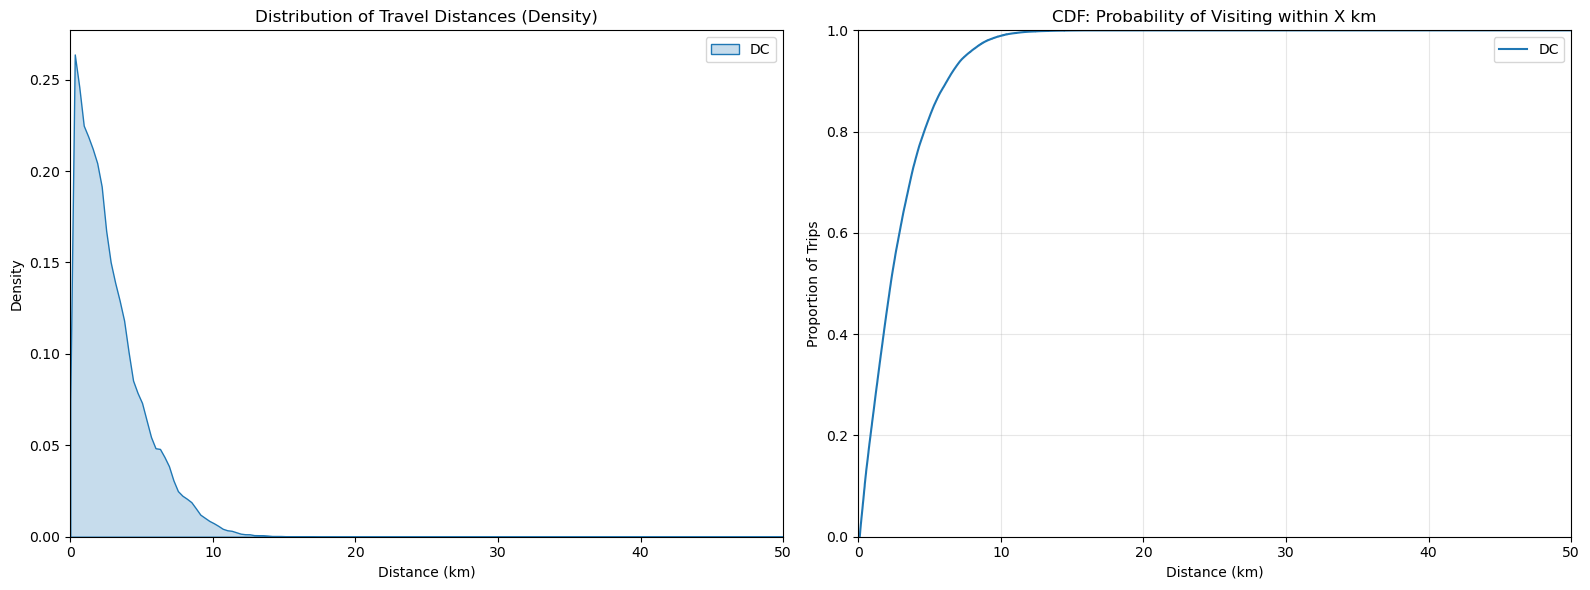

In [20]:
plot_distances(df_full[df_full["State"]=="DC"], "DC")

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Distribution of Travel Distances (Density)'}, xlabel='Distance (km)', ylabel='Density'>,
        <Axes: title={'center': 'CDF: Probability of Visiting within X km'}, xlabel='Distance (km)', ylabel='Proportion of Trips'>],
       dtype=object))

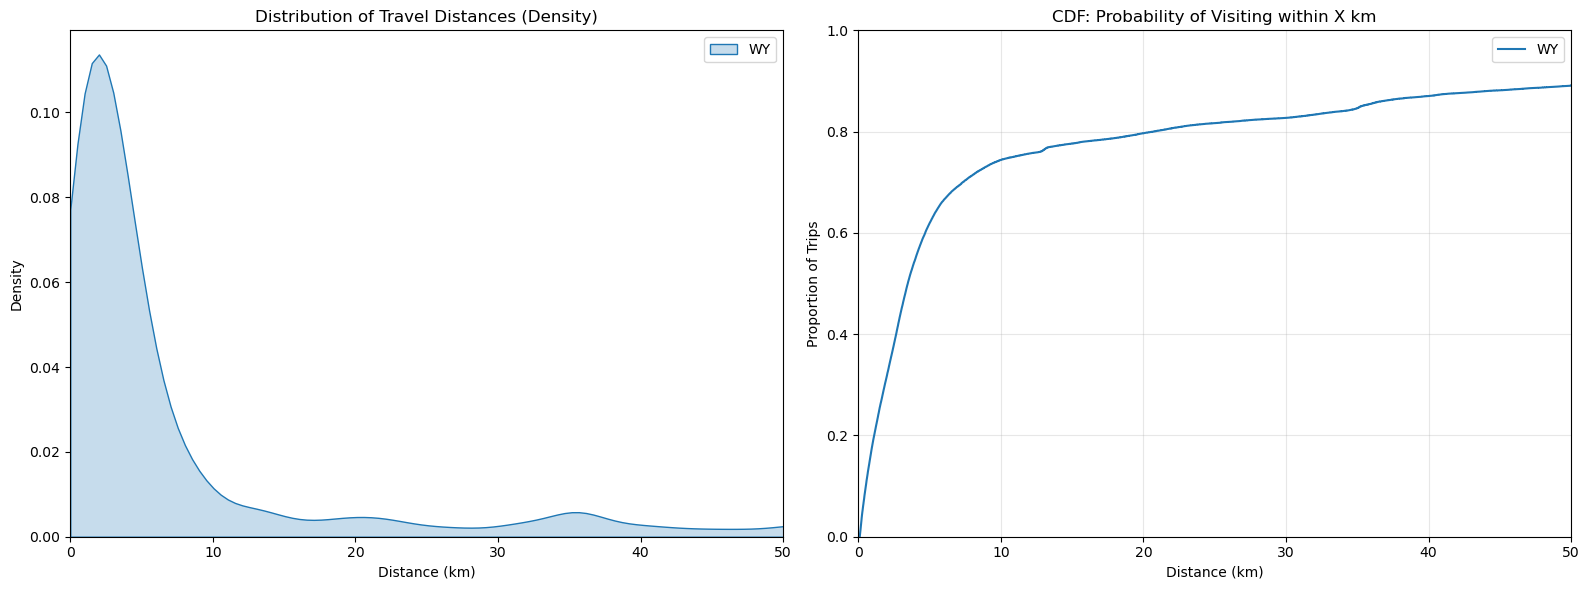

In [21]:
plot_distances(df_full[df_full["State"]=="WY"], "WY")

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'DC: Urban Density (0.5° Window)'}>)

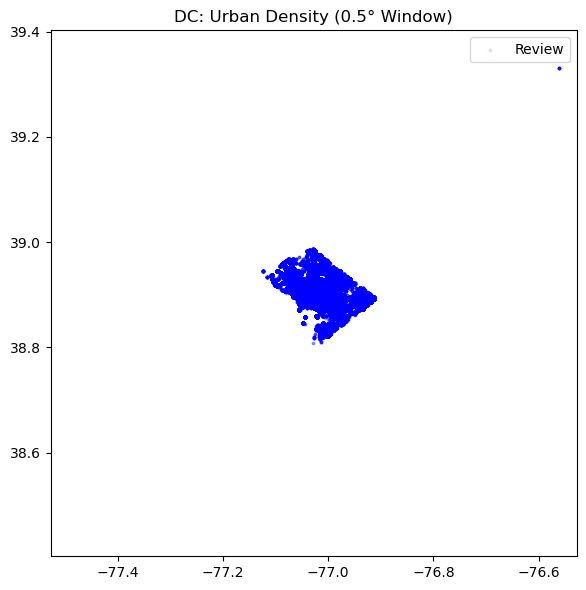

In [24]:
business_density_plot(0.5, df_full[df_full["State"]=="DC"], "DC")

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'WY: Urban Density (0.5° Window)'}>)

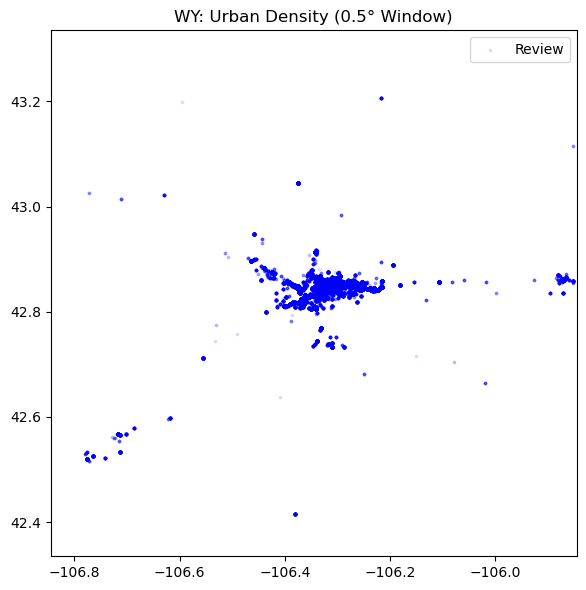

In [23]:
business_density_plot(0.5, df_full[df_full["State"]=="WY"], "WY")

/var/folders/gd/39v8c53x4jb444rgt7l7tcjm0000gp/T/ipykernel_53913/3765550983.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='Review_Count', y='Category_Name', palette='Blues_r', ax=ax)
/var/folders/gd/39v8c53x4jb444rgt7l7tcjm0000gp/T/ipykernel_53913/3765550983.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Top Business Categories (DC)'}, xlabel='Number of Reviews'>)

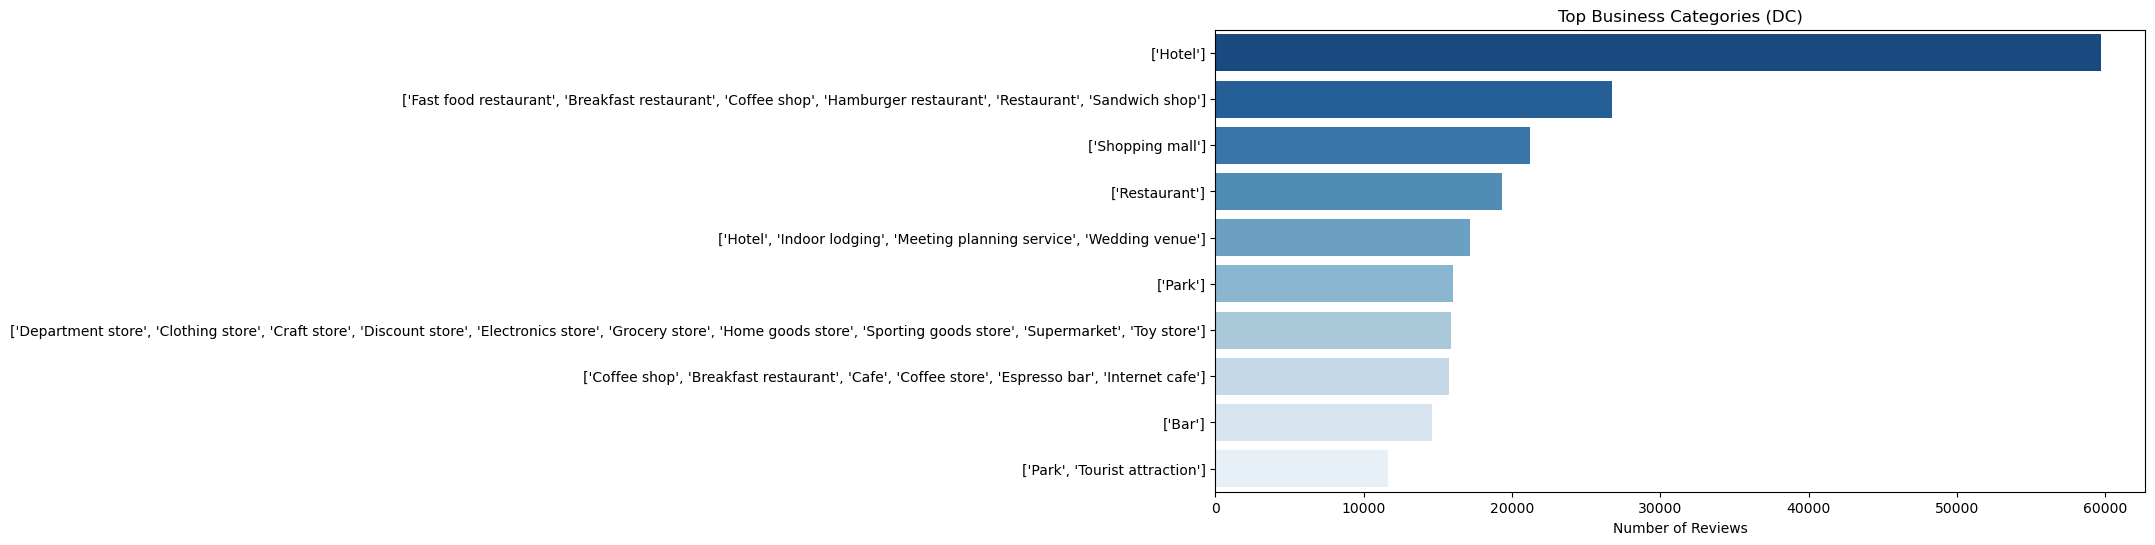

In [25]:
get_top_categories(df_full[df_full["State"]=="DC"], "DC")

/var/folders/gd/39v8c53x4jb444rgt7l7tcjm0000gp/T/ipykernel_53913/3765550983.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='Review_Count', y='Category_Name', palette='Blues_r', ax=ax)
/var/folders/gd/39v8c53x4jb444rgt7l7tcjm0000gp/T/ipykernel_53913/3765550983.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Top Business Categories (WY)'}, xlabel='Number of Reviews'>)

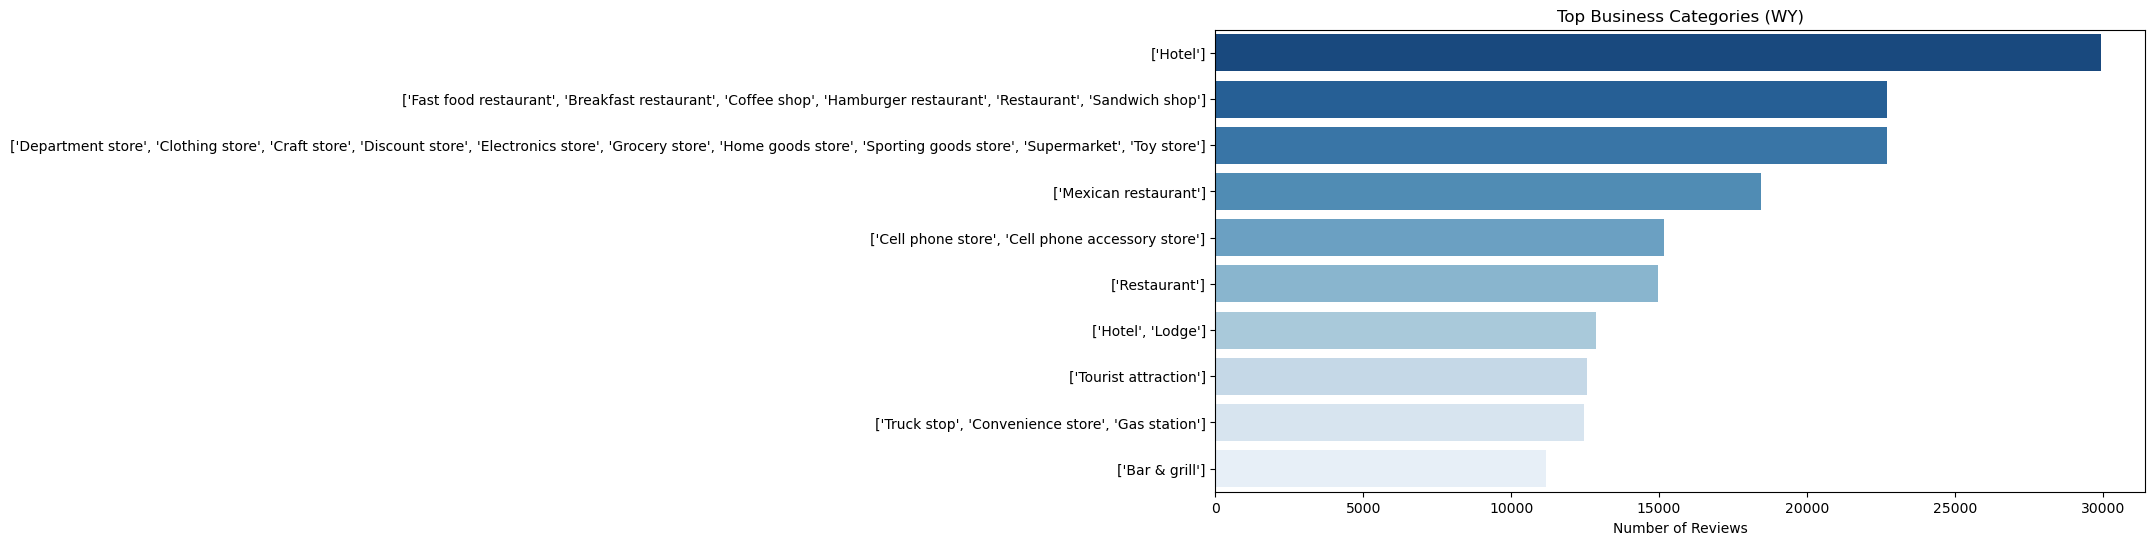

In [26]:
get_top_categories(df_full[df_full["State"]=="WY"], "WY")

In [27]:
# do a train-test split off of the cross-validation data
train_df, test_df, user_history, popular_places, user_sets, place_locs = split_data(df_full)

Train samples: 1857138
Test samples: 407739


In [33]:
# evaluate all methods of item prediction
evaluate_methods(train_df, test_df, user_history, popular_places, user_sets, place_locs, sample_limit=500)

Evaluating users: 100%|██████████| 500/500 [00:12<00:00, 38.64it/s]


--- Results (Hit Rate @ 10) ---
Popularity: 0.0260
Distance:   0.0240
Jaccard:    0.0360
Hybrid:     0.0460
SVD:        0.0700
